In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("beed_master_2015_2024.csv")

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

print(df.head())
print(df.columns)

        date            msl  wind_speed  longwave_radiation  solar_radiation  \
0 2015-01-01  101090.559643    1.207363        3.333532e+07     8.174398e+06   
1 2015-01-02  101337.271875    1.612628        3.232026e+07     1.123444e+07   
2 2015-01-03  101495.967796    2.021170        3.195016e+07     1.261227e+07   
3 2015-01-04  101610.956203    2.790851        3.154876e+07     1.196762e+07   
4 2015-01-05  101561.523795    2.175815        2.989435e+07     1.741315e+07   

   relative_humidity  rainfall       tmax  
0          82.239364  2.560208  24.916723  
1          79.560310  4.189449  26.796510  
2          83.357587  0.151907  27.615252  
3          76.794933  0.000000  26.975063  
4          68.268212  0.000000  28.338764  
Index(['date', 'msl', 'wind_speed', 'longwave_radiation', 'solar_radiation',
       'relative_humidity', 'rainfall', 'tmax'],
      dtype='object')


In [3]:
df['month'] = df['date'].dt.month

In [4]:
test_year = df['date'].dt.year.max()
print("Test year:", test_year)

train_df = df[df['date'].dt.year < test_year].copy()
test_df  = df[df['date'].dt.year == test_year].copy()

print("Train period:", train_df['date'].min(), "to", train_df['date'].max())
print("Test period:", test_df['date'].min(), "to", test_df['date'].max())

Test year: 2024
Train period: 2015-01-01 00:00:00 to 2023-12-31 00:00:00
Test period: 2024-01-01 00:00:00 to 2024-12-31 00:00:00


In [5]:
feature_cols = [
    'msl', 'wind_speed', 'solar_radiation',
       'relative_humidity', 'rainfall', 'month'
]

target_col = 'tmax'

In [6]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

train_df[feature_cols] = scaler_X.fit_transform(train_df[feature_cols])
train_df[[target_col]] = scaler_y.fit_transform(train_df[[target_col]])

test_df[feature_cols] = scaler_X.transform(test_df[feature_cols])
test_df[[target_col]] = scaler_y.transform(test_df[[target_col]])

In [7]:
def create_sequences(data, target, window=4, horizon=15):
    X, y = [], []
    for i in range(len(data) - window - horizon):
        X.append(data[i:i+window])
        y.append(target[i+window:i+window+horizon])
    return np.array(X), np.array(y)

In [8]:
X_train, y_train = create_sequences(
    train_df[feature_cols].values,
    train_df[target_col].values,
    window=4,
    horizon=15
)

X_test, y_test = create_sequences(
    test_df[feature_cols].values,
    test_df[target_col].values,
    window=4,
    horizon=15
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (3268, 4, 6)
y_train shape: (3268, 15)
X_test shape: (347, 4, 6)
y_test shape: (347, 15)


In [9]:
model = Sequential()

model.add(Conv1D(filters=224, kernel_size=1, activation='relu',
                 input_shape=(X_train.shape[1], X_train.shape[2])))

model.add(Conv1D(filters=192, kernel_size=1, activation='relu'))

model.add(Dropout(0.30))

model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64))

model.add(Dropout(0.10))

model.add(Dense(15))

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='mae'
)

model.summary()


c:\Users\sid24\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 4, 224)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 4, 192)         │        43,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 192)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 4, 64)          │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 4, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 15)             │           975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 177,583 (693.68 KB)

 Trainable params: 177,583 (693.68 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(
    X_train, y_train,
    epochs=200,        # you can increase to 400–500 later
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.3758 - val_loss: 0.1755
Epoch 2/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1642 - val_loss: 0.1126
Epoch 3/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1192 - val_loss: 0.0890
Epoch 4/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1018 - val_loss: 0.0876
Epoch 5/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0994 - val_loss: 0.0905
Epoch 6/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0986 - val_loss: 0.0868
Epoch 7/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0973 - val_loss: 0.0860
Epoch 8/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0952 - val_loss: 0.0889
Epoch 9/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0938 - val_loss: 0.0862
Epoch 10/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0925 - val_loss: 0.0852
Epoch 11/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0911 - val_loss: 0.0840
Epoch 12/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.

In [11]:
y_pred = model.predict(X_test)

# Inverse scaling
y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


In [13]:
from sklearn.metrics import mean_squared_error

for i in range(15):
    rmse = np.sqrt(mean_squared_error(y_test_inv[:, i], y_pred_inv[:, i]))
    print(f"Day {i+1} ahead RMSE: {rmse:.3f}")

Day 1 ahead RMSE: 1.373
Day 2 ahead RMSE: 1.449
Day 3 ahead RMSE: 1.498
Day 4 ahead RMSE: 1.547
Day 5 ahead RMSE: 1.577
Day 6 ahead RMSE: 1.596
Day 7 ahead RMSE: 1.607
Day 8 ahead RMSE: 1.657
Day 9 ahead RMSE: 1.688
Day 10 ahead RMSE: 1.692
Day 11 ahead RMSE: 1.695
Day 12 ahead RMSE: 1.675
Day 13 ahead RMSE: 1.655
Day 14 ahead RMSE: 1.670
Day 15 ahead RMSE: 1.669


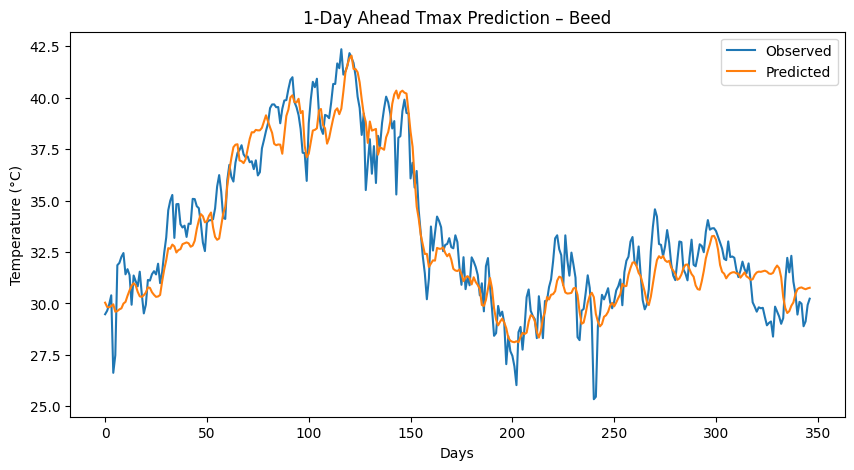

In [14]:
plt.figure(figsize=(10,5))
plt.plot(y_test_inv[:,0], label="Observed")
plt.plot(y_pred_inv[:,0], label="Predicted")
plt.title("1-Day Ahead Tmax Prediction – Beed")
plt.xlabel("Days")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()


In [15]:
test_dates = test_df['date'].iloc[4+15:].reset_index(drop=True)

In [16]:
rmse_df = pd.DataFrame({
    'date': test_dates,
    'obs': y_test_inv[:, 0],   # 1-day ahead observed
    'pred': y_pred_inv[:, 0]   # 1-day ahead predicted
})

rmse_df['month'] = rmse_df['date'].dt.month


In [17]:
from sklearn.metrics import mean_squared_error
import numpy as np

monthly_rmse = rmse_df.groupby('month').apply(
    lambda x: np.sqrt(mean_squared_error(x['obs'], x['pred']))
)

print(monthly_rmse)

month
1     1.870584
2     1.189388
3     1.211640
4     1.376318
5     1.489204
6     1.624317
7     0.955049
8     1.143315
9     1.601239
10    1.228875
11    1.004382
12    1.781833
dtype: float64


C:\Users\sid24\AppData\Local\Temp\ipykernel_18000\24786085.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_rmse = rmse_df.groupby('month').apply(


In [18]:
for lead in range(15):
    rmse_df = pd.DataFrame({
        'date': test_dates,
        'obs': y_test_inv[:, lead],
        'pred': y_pred_inv[:, lead]
    })
    rmse_df['month'] = rmse_df['date'].dt.month
    
    monthly_rmse = rmse_df.groupby('month').apply(
        lambda x: np.sqrt(mean_squared_error(x['obs'], x['pred']))
    )
    
    print(f"\nMonth-wise RMSE for {lead+1}-day ahead:")
    print(monthly_rmse)


Month-wise RMSE for 1-day ahead:
month
1     1.870584
2     1.189388
3     1.211640
4     1.376318
5     1.489204
6     1.624317
7     0.955049
8     1.143315
9     1.601239
10    1.228875
11    1.004382
12    1.781833
dtype: float64

Month-wise RMSE for 2-day ahead:
month
1     1.948013
2     1.234370
3     1.189039
4     1.562203
5     1.693724
6     1.573951
7     1.019591
8     1.235736
9     1.752332
10    1.398035
11    1.081924
12    1.718085
dtype: float64

Month-wise RMSE for 3-day ahead:
month
1     1.904572
2     1.286304
3     1.133659
4     1.709457
5     1.795432
6     1.660670
7     1.076724
8     1.387642
9     1.716021
10    1.497010
11    1.146864
12    1.644442
dtype: float64

Month-wise RMSE for 4-day ahead:
month
1     1.849295
2     1.459373
3     1.028229
4     1.777008
5     2.018723
6     1.783980
7     1.066218
8     1.488797
9     1.662793
10    1.516182
11    1.197386
12    1.575535
dtype: float64

Month-wise RMSE for 5-day ahead:
month
1     1.826925
2    

C:\Users\sid24\AppData\Local\Temp\ipykernel_18000\3708917103.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_rmse = rmse_df.groupby('month').apply(
C:\Users\sid24\AppData\Local\Temp\ipykernel_18000\3708917103.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_rmse = rmse_df.groupby('month').apply(
C:\Users\sid24\AppData\Local\Temp\ipykernel_18000\3708917103.py:9: FutureWarning: DataFrameGroupBy.a